# Import the needed libraries

In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import random
import re
from collections import defaultdict
import time
import warnings
warnings.filterwarnings("ignore")

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

# Data Partition
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Data Normalization
from sklearn.preprocessing import MinMaxScaler

# Wrapper Methods
from sklearn.feature_selection import RFE

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Other models from sklearn
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Model selection with grid search
from sklearn.model_selection import GridSearchCV

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Color Map
from matplotlib.colors import LinearSegmentedColormap

# Classification Report
from sklearn.metrics import classification_report

# Extract the data

In [2]:
# extract the data of the first sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_task_execution = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx')
ds_task_execution_original = ds_task_execution.copy()

In [3]:
# extract the data of the second sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_user_info = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=1)
ds_user_info_original = ds_user_info.copy()

In [4]:
# extract the data of the third sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_specific_request = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=2)
ds_specific_request_original = ds_specific_request.copy()

In [5]:
# extract the data of the fourth sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_rejections = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=3)
ds_rejections_original = ds_rejections.copy()

# 1. Data Exploration and Preparation

### 1.1. Task Execution 

In [6]:
ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Actvity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299


In [7]:
ds_task_execution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209017 entries, 0 to 209016
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Task Id                   209017 non-null  int64  
 1   Request Identifier        209017 non-null  int64  
 2   Task arrival date         209017 non-null  object 
 3   Task capture date         209017 non-null  object 
 4   Task execution end date   209017 non-null  object 
 5   Task predicted end date   163232 non-null  object 
 6   Actvity ID                209017 non-null  int64  
 7   Task Executer             188888 non-null  float64
 8   Task executer department  181887 non-null  float64
 9   Task Type                 209017 non-null  object 
 10  Action                    124576 non-null  object 
 11  idBPMApplicationAction    209017 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 19.1+ MB


In [8]:
# Rename the column Actvity ID to Activity ID
ds_task_execution.rename(columns={'Actvity ID': 'Activity ID'}, inplace=True)

In [9]:
# Check for nulls
ds_task_execution.isnull().sum()

Task Id                         0
Request Identifier              0
Task arrival date               0
Task capture date               0
Task execution end date         0
Task predicted end date     45785
Activity ID                     0
Task Executer               20129
Task executer department    27130
Task Type                       0
Action                      84441
idBPMApplicationAction          0
dtype: int64

In [10]:
# 'Task predicted end date' nulls are all of task type 'Initial Request'

In [11]:
# Check for duplicates
ds_task_execution.duplicated().sum()

0

In [12]:
# Check 'Task Id' values
ds_task_execution['Task Id'].value_counts()

1584303    1
3945953    1
3945749    1
3947939    1
3948764    1
          ..
2528343    1
2528344    1
2531841    1
2532500    1
6863412    1
Name: Task Id, Length: 209017, dtype: int64

In [13]:
# Check 'Request Identifier' values
ds_task_execution['Request Identifier'].value_counts()

38251    26
14835    22
42129    22
27606    21
38766    20
         ..
7698      2
39088     2
27537     2
29429     2
45449     2
Name: Request Identifier, Length: 45772, dtype: int64

In [14]:
# Create a new column with the last Activity ID for each Request Identifier
ds_task_execution['Last Activity ID'] = ds_task_execution.groupby('Request Identifier')['Activity ID'].transform('last')
ds_task_execution.head(12)

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,107
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,107
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,107
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,107
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107
5,1586253,2,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,NaN,100,598.0,606.0,Initial Request,Submit initial request,270,107
6,1586254,2,2022-04-12 10:50:26.147,2022-04-12 10:52:00.203,2022-04-12 12:35:56.390,2022-04-13 08:50:26.197,102,4322.0,1104.0,Execution,NaN,273,107
7,1587111,2,2022-04-12 12:35:56.890,2022-04-12 13:44:25.607,2022-04-12 13:45:24.067,2022-04-13 10:35:56.930,103,10606.0,NaN,Execution,NaN,273,107
8,1587525,2,2022-04-12 13:45:24.847,2022-04-12 13:53:42.120,2022-04-12 14:18:35.850,2022-04-13 11:45:24.960,104,598.0,606.0,Execution,Task executed with success,282,107
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940,107,598.0,606.0,Final task,Request accepted by requester,299,107


In [15]:
# Check all the last activities
ds_task_execution['Last Activity ID'].value_counts()

107    123202
104     79014
101      6485
102       306
105         6
103         4
Name: Last Activity ID, dtype: int64

In [16]:
# Check idBPMApplicationAction unique values
ds_task_execution['idBPMApplicationAction'].unique()

array([ 270,  273,  282,  299,  298,  290,  271, 2981, 8888,  888,  278,
        272,  300,  301,  274,  279,  275,  777, 2982], dtype=int64)

In [17]:
# Example dataframe when the 'Activity ID' is 107
ds_task_execution[ds_task_execution['Activity ID'] == 107]

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940,107,598.0,606.0,Final task,Request accepted by requester,299,107
35,1839129,8,2022-06-14 16:13:12.947,2022-06-14 16:46:06.883,2022-06-14 16:46:46.810,2022-06-22 11:13:13.097,107,7638.0,569.0,Final task,Request accepted by requester,299,107
40,1593793,9,2022-04-14 09:46:55.640,2022-04-14 09:47:36.313,2022-04-14 09:47:54.830,2022-04-21 13:46:55.720,107,10847.0,606.0,Final task,Request accepted by requester,299,107
53,1602749,12,2022-04-19 16:02:08.233,2022-04-27 11:02:08.633,2022-04-27 11:02:08.633,2022-04-27 11:02:08.297,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208995,6692068,45768,2024-04-09 15:32:39.317,2024-04-16 10:32:40.020,2024-04-16 10:32:40.020,2024-04-16 10:32:39.390,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,107
209001,6638514,45769,2024-04-02 11:34:06.487,2024-04-08 15:34:06.770,2024-04-08 15:34:06.770,2024-04-08 15:34:06.540,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,107
209006,6631830,45770,2024-04-01 14:31:21.200,2024-04-01 14:31:42.607,2024-04-01 14:32:14.160,2024-04-08 09:31:21.233,107,7351.0,585.0,Final task,Request accepted by requester,299,107
209010,6729661,45771,2024-04-16 09:15:42.380,2024-04-16 09:19:19.753,2024-04-16 09:20:08.637,2024-04-22 13:15:42.443,107,7945.0,478.0,Final task,Request accepted by requester,299,107


In [18]:
# Function to determine the Target
def determine_target(row):
    
    # Conditions for 'Request Canceled'
    if ((row['Last Activity ID'] == 101 and
         row['Action'] == 'Task automaticaly terminated - SLA time reached') or
        (row['Last Activity ID'] == 101 and
         row['idBPMApplicationAction'] == 298)):
        return 'Request Canceled'
   
    # Conditions for 'Request Finished'
    elif (row['Last Activity ID'] == 107 and
          row['Task Type'] == 'Final task' and
          row['idBPMApplicationAction'] == 299):
        return 'Request Finished'
   
    # Conditions for 'Closed Administratively Requester Rejects Accounting Impact'
    elif (row['Last Activity ID'] == 104 and
          row['Action'] == 'Task terminated - administrative closure'):
        return 'Closed Administratively Requester Rejects Accounting Impact'
   
    # Conditions for 'Closed Administratively'
    elif ((row['Last Activity ID'] in [103, 106, 108] and
           row['idBPMApplicationAction'] in [888, 8888]) or
          (row['Last Activity ID'] == 107 and
           row['Task Type'] == 'Final task' and
           row['idBPMApplicationAction'] in [888, 8888])):        
        return 'Closed Administratively'


In [19]:
# Create new column with the Target and drop the 'Last Activity ID' column 
ds_task_execution['Target'] = ds_task_execution.apply(determine_target, axis=1)

ds_task_execution = ds_task_execution.drop(columns=['Last Activity ID'])

ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,None
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,None
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,None
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,None
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished


In [20]:
# Check 'Target' values cardinality
ds_task_execution['Target'].value_counts(dropna=False)

None                                                           163401
Closed Administratively Requester Rejects Accounting Impact     19678
Closed Administratively                                         15119
Request Finished                                                 9056
Request Canceled                                                 1763
Name: Target, dtype: int64

In [21]:
# Make the Target of the last instance of each Request Identifier the Target of all the same Request Identifier
ds_task_execution['Target'] = ds_task_execution.groupby('Request Identifier')['Target'].transform('last')

In [22]:
ds_task_execution['Target'].value_counts()

Closed Administratively Requester Rejects Accounting Impact    79014
Closed Administratively                                        76902
Request Finished                                               46304
Request Canceled                                                6485
Name: Target, dtype: int64

In [23]:
ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,Request Finished
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,Request Finished
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,Request Finished
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,Request Finished
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished


### 1.2. User Information

In [24]:
ds_user_info.head()

,Task Executer,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer
0,1872,F,1988,1,Yes,2024,N
1,11133,F,1975,1,Yes,2019,N
2,10332,F,1978,2,Yes,2019,N
3,10349,F,1976,3,Yes,2024,N
4,1394,F,1984,4,Yes,2021,N


In [25]:
ds_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Task Executer  11370 non-null  int64 
 1   Sex            11370 non-null  object
 2   BirthYear      11370 non-null  int64 
 3   Role ID        11370 non-null  int64 
 4   Is Manager     11370 non-null  object
 5   OrgUnitSince   11370 non-null  int64 
 6   IsOutSourcer   11370 non-null  object
dtypes: int64(4), object(3)
memory usage: 621.9+ KB


In [26]:
# Check for nulls
ds_user_info.isnull().sum()

Task Executer    0
Sex              0
BirthYear        0
Role ID          0
Is Manager       0
OrgUnitSince     0
IsOutSourcer     0
dtype: int64

In [27]:
# Check for duplicates
ds_user_info.duplicated().sum()

24

In [28]:
# Remove duplicates
ds_user_info.drop_duplicates(inplace=True)
ds_user_info.duplicated().sum()

0

In [29]:
# Check 'Task Executer' values
ds_user_info['Task Executer'].value_counts()

7779     6
7457     5
6955     5
1341     5
1728     5
        ..
10606    1
8650     1
8172     1
8557     1
1257     1
Name: Task Executer, Length: 11274, dtype: int64

In [30]:
# Check how many Task Executers have multiple data info
y = ds_user_info['Task Executer'].value_counts()
count_2_or_more = y[y >= 2].count()
print(count_2_or_more)

45


In [31]:
# Rows with task executer 1728 for example
task_executer_1728 = ds_user_info[ds_user_info['Task Executer'] == 1728]
print(task_executer_1728)

       Task Executer Sex  BirthYear  Role ID Is Manager  OrgUnitSince  \
1390            1728   M       1963       74        Yes          2022   
5420            1728   M       1963       80        Yes          2018   
7106            1728   M       1963       73        Yes          2022   
9970            1728   M       1963       75        Yes          2022   
10020           1728   M       1963       71        Yes          2018   

      IsOutSourcer  
1390             N  
5420             N  
7106             N  
9970             N  
10020            N  


In [32]:
# Check if the repeated task executers are in the dataframe ds_task_execution

repeated_task_executers = ds_user_info['Task Executer'].value_counts()
repeated_task_executers = repeated_task_executers[repeated_task_executers > 1].index

task_executers_in_ds_task_execution = set(ds_task_execution['Task Executer'].unique())

if all(task_executer not in task_executers_in_ds_task_execution for task_executer in repeated_task_executers):
    print("All repeated task executers in ds_user_info are not in ds_task_execution.")
else:
    print("There are repeated task executers in ds_user_info that are also in ds_task_execution.")

All repeated task executers in ds_user_info are not in ds_task_execution.


In [33]:
# Drop repeated 'Task Executer' values
ds_user_info = ds_user_info[~ds_user_info['Task Executer'].isin(repeated_task_executers)]

In [34]:
# Check 'Task Executer' values
ds_user_info['Task Executer'].value_counts()

1872     1
11210    1
4302     1
10781    1
8198     1
        ..
4309     1
6961     1
7185     1
932      1
1257     1
Name: Task Executer, Length: 11229, dtype: int64

### 1.3. Specific Request

In [35]:
ds_specific_request.head()

,idField,Request Identifier,Value
0,47,328,0
1,47,327,0
2,47,291,0
3,47,289,0
4,47,219,0


In [36]:
ds_specific_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297556 entries, 0 to 297555
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   idField             297556 non-null  int64 
 1   Request Identifier  297556 non-null  int64 
 2   Value               297556 non-null  object
dtypes: int64(2), object(1)
memory usage: 6.8+ MB


In [37]:
# Check for nulls
ds_specific_request.isnull().sum()

idField               0
Request Identifier    0
Value                 0
dtype: int64

In [38]:
# Check for duplicates
ds_specific_request.duplicated().sum()

0

In [39]:
# Check 'Request Identifier' values
ds_specific_request['Request Identifier'].value_counts()

328      10
4282     10
3525     10
3480     10
3445     10
         ..
20478     4
20376     4
22208     4
21248     4
37102     4
Name: Request Identifier, Length: 45772, dtype: int64

In [40]:
# Rows with Request Identifier 328 for example
request_identifier_328 = ds_specific_request[ds_specific_request['Request Identifier'] == 328]
print(request_identifier_328)

        idField  Request Identifier                     Value
0            47                 328                         0
16         1602                 328                         0
88978      3491                 328                        10
89147      3420                 328                        10
89476      3486                 328                        10
89856      3388                 328                        10
90166      3390                 328                        10
90544      3391                 328                        10
139116      203                 328  2022-05-08T23:00:00.000Z
290060     1604                 328                        80


In [41]:
# Function to replace strange values in the column 'Value' with Unknown
def replace_values(value):
    if isinstance(value, str) and re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{3}Z', value):
        return 'Unknown'
    return value

In [42]:
# Apply the function to replace values
ds_specific_request['Value'] = ds_specific_request['Value'].apply(replace_values)

In [43]:
# Check new values
ds_specific_request['Value'].unique()

array([0, 1, -1, 10, 100, 2, -2, 20, 'Unknown', 30, 40, 5, 50, 6, 60, 70,
       80, 90], dtype=object)

In [44]:
# Check Request Identifier 328 example
request_identifier_328 = ds_specific_request[ds_specific_request['Request Identifier'] == 328]
print(request_identifier_328)

        idField  Request Identifier    Value
0            47                 328        0
16         1602                 328        0
88978      3491                 328       10
89147      3420                 328       10
89476      3486                 328       10
89856      3388                 328       10
90166      3390                 328       10
90544      3391                 328       10
139116      203                 328  Unknown
290060     1604                 328       80


In [45]:
# Check 'Value' values cardinality
ds_specific_request['Value'].value_counts()

10         85761
Unknown    45772
50         35153
30         28320
70         22450
20         20092
100        19520
60         12935
2           7988
40          6075
1           4681
80          4081
90          3579
5            353
0            246
-1           209
-2           178
6            163
Name: Value, dtype: int64

### 1.4. Rejections

In [46]:
ds_rejections.head()

,Task Id,idBPMRequirement
0,1606251,191
1,1606786,183
2,1629944,183
3,1643257,183
4,1643929,183


In [47]:
ds_rejections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Task Id           4099 non-null   int64
 1   idBPMRequirement  4099 non-null   int64
dtypes: int64(2)
memory usage: 64.2 KB


In [48]:
# Check for nulls
ds_rejections.isnull().sum()

Task Id             0
idBPMRequirement    0
dtype: int64

In [49]:
# Check for duplicates
ds_rejections.duplicated().sum()

0

In [50]:
# Check 'Task Id' values cardinality
ds_rejections['Task Id'].value_counts()

1654061    7
1647860    6
1925405    2
2999956    2
3139691    2
          ..
3266189    1
3266202    1
3266928    1
3267685    1
6636734    1
Name: Task Id, Length: 4056, dtype: int64

In [51]:
# Rows with Task Id 1654061 for example
task_id_1654061 = ds_rejections[ds_rejections['Task Id'] == 1654061]
print(task_id_1654061)

    Task Id  idBPMRequirement
20  1654061               183
21  1654061               191
22  1654061               300
23  1654061               331
24  1654061               353
25  1654061               661
26  1654061              1436


### 1.5. Merge the datasets

In [52]:
# Merge the Task Execution with the User Information by Task Executer
ds_joined = pd.merge(ds_task_execution, ds_user_info, on='Task Executer', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,Request Finished,M,1967.0,5.0,Yes,2021.0,N
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,Request Finished,F,1967.0,21.0,No,2024.0,Y
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,Request Finished,F,1975.0,11.0,Yes,2023.0,N
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,Request Finished,M,1967.0,5.0,Yes,2021.0,N
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished,M,1967.0,5.0,Yes,2021.0,N


In [53]:
ds_joined.shape

(209017, 19)

In [54]:
# Aggregate the columns 'idField' and 'Value' from ds_specific_request to merge with ds_joined
ds_specific_request_aggregated = ds_specific_request.groupby('Request Identifier').agg({
    'idField': lambda x: ','.join(map(str, x)),
    'Value': lambda x: ','.join(map(str, x))
}).reset_index()

ds_specific_request_aggregated.head()

,Request Identifier,idField,Value
0,1,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
1,2,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown"
2,3,"3390,3420,203,3388,3486","10,10,Unknown,30,30"
3,4,"3486,3388,3390,3420,203","10,10,10,20,Unknown"
4,5,"3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30"


In [55]:
# Merge the ds_joined with the ds_specific_request_aggregated by Request Identifier
ds_joined = pd.merge(ds_joined, ds_specific_request_aggregated, on='Request Identifier', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,...,270,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,...,273,Request Finished,F,1967.0,21.0,No,2024.0,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,...,273,Request Finished,F,1975.0,11.0,Yes,2023.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,...,282,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,...,299,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"


In [56]:
ds_joined.shape

(209017, 21)

In [57]:
# Aggregate the column 'idBPMRequirement' from ds_rejections to merge with ds_joined
ds_rejections_aggregated = ds_rejections.groupby('Task Id').agg({
    'idBPMRequirement': lambda x: ','.join(map(str, x))}).reset_index()

ds_rejections_aggregated.head()

,Task Id,idBPMRequirement
0,1606251,191
1,1606786,183
2,1629944,183
3,1643257,183
4,1643929,183


In [58]:
# Check if the values from the column 'idBPMRequirement' are aggregated
agg_task_id_1654061 = ds_rejections_aggregated[ds_rejections_aggregated['Task Id'] == 1654061]
print(agg_task_id_1654061)

    Task Id              idBPMRequirement
15  1654061  183,191,300,331,353,661,1436


In [59]:
# Merge the ds_joined with the ds_rejections_aggregated by Task Id
ds_joined = pd.merge(ds_joined, ds_rejections_aggregated, on='Task Id', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,...,Request Finished,F,1967.0,21.0,No,2024.0,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,...,Request Finished,F,1975.0,11.0,Yes,2023.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN


In [60]:
ds_joined.shape

(209017, 22)

In [61]:
# Clean data values
columns_to_convert = ['Task Executer', 'Task executer department', 'BirthYear', 'Role ID', 'OrgUnitSince']

for col in columns_to_convert:
    ds_joined[col] = ds_joined[col].astype(str).str.rstrip('.0')
    ds_joined[col] = ds_joined[col].replace('nan', np.nan)

In [62]:
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638,569,Initial Request,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322,1104,Execution,...,Request Finished,F,1967,21,No,2024,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606,NaN,Execution,...,Request Finished,F,1975,11,Yes,2023,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638,569,Execution,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638,569,Final task,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN


In [63]:
# Change the columns data types
cols_to_object = ['Task Id', 'Request Identifier', 'Activity ID', 'Task Executer', 'Task executer department', 'idBPMApplicationAction', 'Role ID']
for col in cols_to_object:
    ds_joined[col] = ds_joined[col].astype('object')

ds_joined['Task arrival date'] = pd.to_datetime(ds_joined['Task arrival date'])
ds_joined['Task capture date'] = pd.to_datetime(ds_joined['Task capture date'])
ds_joined['Task execution end date'] = pd.to_datetime(ds_joined['Task execution end date'])
ds_joined['Task predicted end date'] = pd.to_datetime(ds_joined['Task predicted end date'])

In [64]:
ds_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209017 entries, 0 to 209016
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Task Id                   209017 non-null  object        
 1   Request Identifier        209017 non-null  object        
 2   Task arrival date         209017 non-null  datetime64[ns]
 3   Task capture date         209017 non-null  datetime64[ns]
 4   Task execution end date   209017 non-null  datetime64[ns]
 5   Task predicted end date   163232 non-null  datetime64[ns]
 6   Activity ID               209017 non-null  object        
 7   Task Executer             188888 non-null  object        
 8   Task executer department  181887 non-null  object        
 9   Task Type                 209017 non-null  object        
 10  Action                    124576 non-null  object        
 11  idBPMApplicationAction    209017 non-null  object        
 12  Ta

### 1.6. Outliers

In [65]:
# Looping cases and possible outliers
ds_joined['Request Identifier'].value_counts()

38251    26
14835    22
42129    22
27606    21
38766    20
         ..
7698      2
39088     2
27537     2
29429     2
45449     2
Name: Request Identifier, Length: 45772, dtype: int64

In [66]:
# Mean of 'Request Identifier' values cardinality
ds_joined['Request Identifier'].value_counts().mean()

4.566481691864022

In [67]:
# Check possible looping cases
x = ds_joined['Request Identifier'].value_counts()
count_8_or_more = x[x >= 8].count()
print(count_8_or_more)

1821


In [68]:
# Drop looping cases
request_identifier_counts = ds_joined['Request Identifier'].value_counts()
looping_cases = request_identifier_counts[request_identifier_counts >= 8].index

ds_joined = ds_joined[~ds_joined['Request Identifier'].isin(looping_cases)]

In [69]:
ds_joined.shape

(192019, 22)

### 1.7. Missing Values
     
     We will take different approaches to impute missing values of different variables, depending on the % of missing values and what makes more sense given the context and our understanding of the variable in cause 

In [70]:
ds_joined.isna().sum()

Task Id                          0
Request Identifier               0
Task arrival date                0
Task capture date                0
Task execution end date          0
Task predicted end date      43962
Activity ID                      0
Task Executer                18810
Task executer department     25982
Task Type                        0
Action                       76110
idBPMApplicationAction           0
Target                         312
Sex                          18810
BirthYear                    18810
Role ID                      18810
Is Manager                   18810
OrgUnitSince                 18810
IsOutSourcer                 18810
idField                          0
Value                            0
idBPMRequirement            189333
dtype: int64

#### - Task predicted end date

In [71]:
# Check how many times the 'Task type' is 'Initial Request'
task_type_initial_request = ds_joined[ds_joined['Task Type'] == 'Initial Request']
task_type_initial_request.shape

(43951, 22)

In [72]:
# Fill missing values with 'Not necessary' 
ds_joined['Task predicted end date'] = ds_joined['Task predicted end date'].fillna('Not necessary')

#### - Task Executer

In [73]:
ds_joined['Task Executer'].value_counts()

10606    30298
496      15591
4731     11809
4322     11068
10925     2186
         ...  
8            1
1683         1
1197         1
1959         1
10318        1
Name: Task Executer, Length: 1561, dtype: int64

In [74]:
# Fill missing values with Unknown
ds_joined['Task Executer'] = ds_joined['Task Executer'].fillna('Unknown')

#### - Task executer department

In [75]:
ds_joined['Task executer department'].value_counts()

1146    23384
1104    21184
1147    15769
1172     7182
1177     4233
        ...  
454         1
101         1
307         1
37          1
113         1
Name: Task executer department, Length: 377, dtype: int64

In [76]:
# Fill missing values with Unknown
ds_joined['Task executer department'] = ds_joined['Task executer department'].fillna('Unknown')

#### - Action

In [77]:
ds_joined['Action'].value_counts()

Submit initial request                             43954
Task executed with success                         22756
Task terminated - administrative closure           19364
Task automaticaly terminated - SLA time reached    15693
Request accepted by requester                       8491
Task returned to team                               5651
Name: Action, dtype: int64

In [78]:
# Fill missing values with Unknown
ds_joined['Action'] = ds_joined['Action'].fillna('Unknown')

#### - Target

In [79]:
ds_joined['Target'].value_counts()

Closed Administratively Requester Rejects Accounting Impact    76120
Closed Administratively                                        68593
Request Finished                                               40910
Request Canceled                                                6084
Name: Target, dtype: int64

In [80]:
# Check rows when the 'Target' is None
ds_joined_output_none = ds_joined[ds_joined['Target'].isna()]
ds_joined_output_none

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
10,1589361,3,2022-04-12 18:09:29.153,2022-04-12 18:09:29.153,2022-04-12 18:09:29.153,Not necessary,100,11029,167,Initial Request,...,None,F,1975,5,Yes,2021,N,"3390,3420,203,3388,3486","10,10,Unknown,30,30",NaN
11,1589362,3,2022-04-12 18:09:29.607,2022-04-13 13:16:14.933,2022-04-13 13:16:14.933,2022-04-13 15:30:00.690000,102,11029,167,Execution,...,None,F,1975,5,Yes,2021,N,"3390,3420,203,3388,3486","10,10,Unknown,30,30",NaN
4435,1735647,981,2022-05-20 09:55:14.947,2022-05-20 09:55:14.947,2022-05-20 09:55:14.947,Not necessary,100,10309,251,Initial Request,...,None,M,1975,5,Yes,2021,N,"3388,3420,203,3486","20,20,Unknown,50",NaN
4436,1735648,981,2022-05-20 09:55:17.057,2022-05-20 10:41:49.123,2022-05-20 10:41:49.123,2022-05-20 16:55:17.217000,102,10309,251,Execution,...,None,M,1975,5,Yes,2021,N,"3388,3420,203,3486","20,20,Unknown,50",NaN
4896,1741603,1084,2022-05-23 11:46:50.763,2022-05-23 11:46:50.763,2022-05-23 11:46:50.763,Not necessary,100,Unknown,659,Initial Request,...,None,NaN,NaN,NaN,NaN,NaN,NaN,"3390,3388,3420,203,3486","10,20,20,Unknown,50",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203366,6362401,44674,2024-03-04 09:37:50.293,2024-03-04 09:47:20.393,2024-03-04 09:47:20.397,2024-03-04 16:37:50.407000,102,10169,8,Execution,...,None,F,1976,5,Yes,202,N,"3388,3390,203,3486","10,10,Unknown,50",NaN
203439,6373933,44690,2024-03-04 10:52:57.290,2024-03-04 10:52:57.290,2024-03-04 10:52:57.290,Not necessary,100,7847,234,Initial Request,...,None,F,1972,5,Yes,202,N,"3390,203,3486,3388","10,Unknown,30,30",NaN
203440,6373935,44690,2024-03-04 10:52:57.690,2024-03-04 11:06:37.237,2024-03-04 11:06:37.237,2024-03-05 08:52:57.817000,102,7847,234,Execution,...,None,F,1972,5,Yes,202,N,"3390,203,3486,3388","10,Unknown,30,30",NaN
207338,6555259,45449,2024-03-20 09:26:12.347,2024-03-20 09:26:12.347,2024-03-20 09:26:12.347,Not necessary,100,358,599,Initial Request,...,None,M,1976,5,Yes,2014,N,"203,3390,3486,3388","Unknown,30,30,50",NaN


###### The 'Target' is nan/none when the last activity of the case is 102 or 105, but according to the schema, the process can´t end at 102 or 105

In [81]:
# Drop rows when 'Target' is nan
ds_joined = ds_joined.dropna(subset=['Target'])

In [82]:
# Check 'Target' values cardinality
ds_joined['Target'].value_counts(dropna = False)

Closed Administratively Requester Rejects Accounting Impact    76120
Closed Administratively                                        68593
Request Finished                                               40910
Request Canceled                                                6084
Name: Target, dtype: int64

In [83]:
ds_joined.shape

(191707, 22)

#### - User information data (Sex, BirthYear, Role ID, Is Manager, OrgUnitSince, IsOutSourcer)

In [84]:
# Check if all task executers from ds_task_execution are in ds_user_info
all_task_executers_in_ds_user_info = set(ds_user_info['Task Executer'].unique())
task_executers_in_ds_task_execution = set(ds_task_execution['Task Executer'].unique())

if all(task_executer in all_task_executers_in_ds_user_info for task_executer in task_executers_in_ds_task_execution):
    print("All task executers from ds_task_execution are in ds_user_info.")
else:
    print("There are task executers in ds_task_execution that are not in ds_user_info.")

There are task executers in ds_task_execution that are not in ds_user_info.


In [85]:
# Fill missing values with 'Unknown'

ds_joined['Sex'] = ds_joined['Sex'].fillna('Unknown')
ds_joined['BirthYear'] = ds_joined['BirthYear'].fillna('Unknown')
ds_joined['Role ID'] = ds_joined['Role ID'].fillna('Unknown')
ds_joined['Is Manager'] = ds_joined['Is Manager'].fillna('Unknown')
ds_joined['OrgUnitSince'] = ds_joined['OrgUnitSince'].fillna('Unknown')
ds_joined['IsOutSourcer'] = ds_joined['IsOutSourcer'].fillna('Unknown')

#### - idBPMRequirement

In [86]:
ds_joined['idBPMRequirement'].value_counts()

183                             1152
300                             1096
331                              155
191                              127
353                               79
661                               48
183,353                            8
183,300                            8
1436                               7
300,353                            2
183,191,300,331,353,661,1436       1
300,331                            1
183,191                            1
300,1436                           1
Name: idBPMRequirement, dtype: int64

In [87]:
# Fill missing values with 'Not Applicable'
ds_joined['idBPMRequirement'] = ds_joined['idBPMRequirement'].fillna('Not Applicable')

In [88]:
# Check if there are still missing values
ds_joined.isna().sum()

Task Id                     0
Request Identifier          0
Task arrival date           0
Task capture date           0
Task execution end date     0
Task predicted end date     0
Activity ID                 0
Task Executer               0
Task executer department    0
Task Type                   0
Action                      0
idBPMApplicationAction      0
Target                      0
Sex                         0
BirthYear                   0
Role ID                     0
Is Manager                  0
OrgUnitSince                0
IsOutSourcer                0
idField                     0
Value                       0
idBPMRequirement            0
dtype: int64

# 2. Preprocessing 

In [89]:
# Check dataframe
ds_joined.head(10)

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,Not necessary,100,7638,569,Initial Request,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803000,102,4322,1104,Execution,...,Request Finished,F,1967,21,No,2024,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577000,103,10606,Unknown,Execution,...,Request Finished,F,1975,11,Yes,2023,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490000,104,7638,569,Execution,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737000,107,7638,569,Final task,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
5,1586253,2,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,Not necessary,100,598,606,Initial Request,...,Request Finished,F,1979,5,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
6,1586254,2,2022-04-12 10:50:26.147,2022-04-12 10:52:00.203,2022-04-12 12:35:56.390,2022-04-13 08:50:26.197000,102,4322,1104,Execution,...,Request Finished,F,1967,21,No,2024,Y,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
7,1587111,2,2022-04-12 12:35:56.890,2022-04-12 13:44:25.607,2022-04-12 13:45:24.067,2022-04-13 10:35:56.930000,103,10606,Unknown,Execution,...,Request Finished,F,1975,11,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
8,1587525,2,2022-04-12 13:45:24.847,2022-04-12 13:53:42.120,2022-04-12 14:18:35.850,2022-04-13 11:45:24.960000,104,598,606,Execution,...,Request Finished,F,1979,5,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940000,107,598,606,Final task,...,Request Finished,F,1979,5,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable


In [90]:
ds_joined['OrgUnitSince'].unique()

array(['2021', '2024', '2023', '202', '2014', '2017', 'Unknown', '2022',
       '2019', '2016', '2013', '2009', '2015', '2018', '2011', '2012',
       '201', '2004', '2008', '2005', '2006', '2007', '2001'],
      dtype=object)

In [91]:
# Correct 'OrgUnitSince' column values
ds_joined['OrgUnitSince'] = ds_joined['OrgUnitSince'].replace({'197': '1970', '202': '2020'})

In [92]:
ds_joined['OrgUnitSince'].value_counts()

2023       71088
2024       43667
2022       21161
Unknown    18798
2021       11180
2020        6880
2019        6725
2018        2913
2016        2716
2017        2648
2013         743
2012         728
2014         711
2015         686
2009         418
201          238
2011         137
2004         127
2005          87
2008          26
2001          17
2007           7
2006           6
Name: OrgUnitSince, dtype: int64

In [93]:
# Correct 'BirthYear' column values
ds_joined['BirthYear'] = ds_joined['BirthYear'].replace({'201': '2010', '2': '2000', '196': '1960', '198': '1980', '197': '1970', '199': '1990'})

In [94]:
ds_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191707 entries, 0 to 209016
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Task Id                   191707 non-null  object        
 1   Request Identifier        191707 non-null  object        
 2   Task arrival date         191707 non-null  datetime64[ns]
 3   Task capture date         191707 non-null  datetime64[ns]
 4   Task execution end date   191707 non-null  datetime64[ns]
 5   Task predicted end date   191707 non-null  object        
 6   Activity ID               191707 non-null  object        
 7   Task Executer             191707 non-null  object        
 8   Task executer department  191707 non-null  object        
 9   Task Type                 191707 non-null  object        
 10  Action                    191707 non-null  object        
 11  idBPMApplicationAction    191707 non-null  object        
 12  Ta

In [95]:
# Group 'BirthYear' values in decades

intervals = [
    (1950, 1959, "1950-1959"),
    (1960, 1969, "1960-1969"),
    (1970, 1979, "1970-1979"),
    (1980, 1989, "1980-1989"),
    (1990, 1999, "1990-1999"),
    (2000, 2009, "2000-2009")
]

# Function to group values 
def categorize_birthyear(year):
    if year == "Unknown":
        return "Unknown"
    year = int(year)
    for start, end, label in intervals:
        if start <= year <= end:
            return label
    return "Other"

# Apply the function 
ds_joined['BirthYear'] = ds_joined['BirthYear'].apply(categorize_birthyear)

In [96]:
# Group less common values into 'other' for different variables

# 'idBPMApplicationAction'
value_counts = ds_joined['idBPMApplicationAction'].value_counts()
mask = value_counts < 10000
ds_joined['idBPMApplicationAction'] = ds_joined['idBPMApplicationAction'].apply(
    lambda x: 'other' if mask[x] else str(x)
)

# 'Role ID'
value_counts = ds_joined['Role ID'].value_counts()
mask = value_counts < 5000
ds_joined['Role ID'] = ds_joined['Role ID'].apply(
    lambda x: 'other' if mask[x] else str(x)
)

# 'OrgUnitSince'
value_counts = ds_joined['OrgUnitSince'].value_counts()
mask = value_counts < 5000
ds_joined['OrgUnitSince'] = ds_joined['OrgUnitSince'].apply(
    lambda x: 'other' if mask[x] else str(x)
)

In [97]:
#Create a new variable 'Task predicted end date'

# Replace 'Not necessary' with nans and change the datatype to apply the function
ds_joined['Task predicted end date'] = ds_joined['Task predicted end date'].replace('Not necessary', np.nan)
ds_joined['Task predicted end date'] = pd.to_datetime(ds_joined['Task predicted end date'], errors='coerce')

# Function to create a new variable 'Task predicted end date' based on the columns 'Task execution end date' and 'Task predicted end date'  
def create_label(row):
    if pd.isna(row['Task predicted end date']):
        return 'Unknown'
    elif row['Task execution end date'] < row['Task predicted end date']:
        return 'Yes'
    else:
        return 'No'

# Apply the function
ds_joined['task_ended_before_predicted'] = ds_joined.apply(create_label, axis=1)

In [98]:
# Drop columns
ds_joined = ds_joined.drop(columns=['Task Id', 'Task arrival date', 'Task capture date', 'Task execution end date', 'Task predicted end date'])

In [99]:
ds_joined.head()

,Request Identifier,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement,task_ended_before_predicted
0,1,100,7638,569,Initial Request,Submit initial request,270,Request Finished,M,1960-1969,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Unknown
1,1,102,4322,1104,Execution,Unknown,273,Request Finished,F,1960-1969,21,No,2024,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Yes
2,1,103,10606,Unknown,Execution,Unknown,273,Request Finished,F,1970-1979,11,Yes,2023,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Yes
3,1,104,7638,569,Execution,Task executed with success,282,Request Finished,M,1960-1969,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,No
4,1,107,7638,569,Final task,Request accepted by requester,other,Request Finished,M,1960-1969,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Yes


In [100]:
# Check if we can drop 'Is Manager' or 'IsOutSourcer' due to their correlation

# Create a new df that only includes the rows when 'Is Manager' is Yes
is_manager_yes = ds_joined[ds_joined['Is Manager'] == 'Yes']
is_manager_yes['Is Manager'].value_counts(dropna=False)

Yes    131672
Name: Is Manager, dtype: int64

In [101]:
is_manager_yes['IsOutSourcer'].value_counts(dropna=False)

N    131672
Name: IsOutSourcer, dtype: int64

In [102]:
# Create a new df that only includes the rows when 'Is Manager' is No
is_manager_no = ds_joined[ds_joined['Is Manager'] == 'No']
is_manager_no['Is Manager'].value_counts(dropna=False)

No    41237
Name: Is Manager, dtype: int64

In [103]:
is_manager_no['IsOutSourcer'].value_counts(dropna=False)

Y    41237
Name: IsOutSourcer, dtype: int64

In [104]:
# Drop 'IsOutSourcer' column
ds_joined = ds_joined.drop(columns=['IsOutSourcer'])

# 3. Group and aggregate dataframes

In [105]:
# Function to aggregate dataframes
def group_and_aggregate_dataframe(df):        
    # Define the aggregation dictionary
    aggregation_dict = {
        "Activity ID": lambda x: list(x),
        "Task Executer": lambda x: list(x),
        "Task executer department": lambda x: list(x),
        "Task Type": lambda x: list(x),
        "Action": lambda x: list(x),
        "idBPMApplicationAction": lambda x: list(x),
        "Target": 'first',
        "Sex": lambda x: list(x),
        "BirthYear": lambda x: list(x),
        "Role ID": lambda x: list(x),
        'Is Manager': lambda x: list(x),
        "OrgUnitSince": lambda x: list(x),
        "idField": 'first',
        "Value": 'first',
        "idBPMRequirement": lambda x: list(x),
        "task_ended_before_predicted": lambda x: list(x),
    }
    
    # Group by 'Request Identifier' and perform aggregation
    grouped_df = df.groupby("Request Identifier").agg(aggregation_dict).reset_index()
    
    return grouped_df

In [106]:
# Apply the function to our dataframe
ds_grouped = group_and_aggregate_dataframe(ds_joined)

In [107]:
ds_grouped.head()

,Request Identifier,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,idField,Value,idBPMRequirement,task_ended_before_predicted
0,1,"[100, 102, 103, 104, 107]","[7638, 4322, 10606, 7638, 7638]","[569, 1104, Unknown, 569, 569]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Unknown, Unknown, Tas...","[270, 273, 273, 282, other]",Request Finished,"[M, F, F, M, M]","[1960-1969, 1960-1969, 1970-1979, 1960-1969, 1...","[5, 21, 11, 5, 5]","[Yes, No, Yes, Yes, Yes]","[2021, 2024, 2023, 2021, 2021]","1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, Yes, Yes, No, Yes]"
1,2,"[100, 102, 103, 104, 107]","[598, 4322, 10606, 598, 598]","[606, 1104, Unknown, 606, 606]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Unknown, Unknown, Tas...","[270, 273, 273, 282, other]",Request Finished,"[F, F, F, F, F]","[1970-1979, 1960-1969, 1970-1979, 1970-1979, 1...","[5, 21, 11, 5, 5]","[Yes, No, Yes, Yes, Yes]","[2023, 2024, 2023, 2023, 2023]","3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, Yes, Yes, Yes, Yes]"
2,4,"[100, 102, 102, 101]","[924, 538, 507, Unknown]","[569, 1301, 1336, Unknown]","[Initial Request, Execution, Execution, Reques...","[Submit initial request, Task returned to team...","[270, other, other, other]",Request Canceled,"[M, M, M, Unknown]","[1980-1989, 1980-1989, 1980-1989, Unknown]","[6, other, 11, Unknown]","[Yes, Yes, Yes, Unknown]","[2020, other, other, Unknown]","3486,3388,3390,3420,203","10,10,10,20,Unknown","[Not Applicable, Not Applicable, 191, Not Appl...","[Unknown, No, No, No]"
3,5,"[100, 102, 102, 103, 104]","[8601, 507, 4322, 73, 8601]","[167, 1336, 1104, Unknown, 167]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Task returned to team...","[270, other, 273, 273, 8888]",Closed Administratively Requester Rejects Acco...,"[M, M, F, M, M]","[1960-1969, 1980-1989, 1960-1969, 1970-1979, 1...","[5, 11, 21, 8, 5]","[Yes, Yes, No, Yes, Yes]","[2021, other, 2024, 2022, 2021]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, No, No, No, No]"
4,6,"[100, 102, 102, 103, 104]","[11029, 507, 4322, 10925, 9973]","[167, 1336, 1104, Unknown, 167]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Task returned to team...","[270, other, 273, 273, 8888]",Closed Administratively Requester Rejects Acco...,"[F, M, F, F, M]","[1970-1979, 1980-1989, 1960-1969, 1970-1979, 1...","[5, 11, 21, 8, 5]","[Yes, Yes, No, Yes, Yes]","[2021, other, 2024, 2022, 2020]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, No, No, Yes, No]"


# 4. Create new prefix dataframes

In [108]:
# Function to create prefix dataframes with n activities

def create_prefix_dfs(df, max_values=7):
    
    subset_dfs = []    
    
    for n in range(1, max_values + 1):
        subset_df = df.applymap(lambda x: x[:n] if isinstance(x, list) and len(x) >= n else x if not isinstance(x, list) else None)
        subset_df.dropna(axis=1, how='all', inplace=True)
        # Drop rows with any 'None' values
        subset_df.dropna(axis=0, how='any', inplace=True)
        subset_dfs.append(subset_df)
    
    return subset_dfs

In [109]:
# Apply function to our dataframe
subset_dfs = create_prefix_dfs(ds_grouped)

In [110]:
# Naming the prefix dataframes
prefix1, prefix2, prefix3, prefix4, prefix5, prefix6, prefix7 = subset_dfs

In [111]:
prefix3

,Request Identifier,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,idField,Value,idBPMRequirement,task_ended_before_predicted
0,1,"[100, 102, 103]","[7638, 4322, 10606]","[569, 1104, Unknown]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Unknown]","[270, 273, 273]",Request Finished,"[M, F, F]","[1960-1969, 1960-1969, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2021, 2024, 2023]","1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
1,2,"[100, 102, 103]","[598, 4322, 10606]","[606, 1104, Unknown]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Unknown]","[270, 273, 273]",Request Finished,"[F, F, F]","[1970-1979, 1960-1969, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2023, 2024, 2023]","3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
2,4,"[100, 102, 102]","[924, 538, 507]","[569, 1301, 1336]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, other]",Request Canceled,"[M, M, M]","[1980-1989, 1980-1989, 1980-1989]","[6, other, 11]","[Yes, Yes, Yes]","[2020, other, other]","3486,3388,3390,3420,203","10,10,10,20,Unknown","[Not Applicable, Not Applicable, 191]","[Unknown, No, No]"
3,5,"[100, 102, 102]","[8601, 507, 4322]","[167, 1336, 1104]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 273]",Closed Administratively Requester Rejects Acco...,"[M, M, F]","[1960-1969, 1980-1989, 1960-1969]","[5, 11, 21]","[Yes, Yes, No]","[2021, other, 2024]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, No, No]"
4,6,"[100, 102, 102]","[11029, 507, 4322]","[167, 1336, 1104]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 273]",Closed Administratively Requester Rejects Acco...,"[F, M, F]","[1970-1979, 1980-1989, 1960-1969]","[5, 11, 21]","[Yes, Yes, No]","[2021, other, 2024]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, No, No]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43790,45768,"[100, 102, 102]","[61, 6266, 10606]","[453, 1146, 1147]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 273]",Closed Administratively,"[F, M, F]","[1970-1979, 1990-1999, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2023, 2023, 2023]","3390,3491,203,3388,3486,3391","10,10,Unknown,50,50,70","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, No]"
43791,45769,"[100, 102, 103]","[9549, 6266, 10606]","[347, 1146, 1147]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Unknown]","[270, 273, 300]",Closed Administratively,"[M, M, F]","[1970-1979, 1990-1999, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2024, 2023, 2023]","3491,3390,203,3388,3486,3391","10,100,Unknown,50,50,70","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
43792,45770,"[100, 102, 102]","[7351, 6266, 10606]","[585, 1146, 1147]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 275]",Request Finished,"[M, M, F]","[1960-1969, 1990-1999, 1970-1979]","[4, 21, 11]","[Yes, No, Yes]","[2022, 2023, 2023]","3390,1604,47,1602,203,3486,3388,3935,3391","10,100,2,2,Unknown,30,40,50,60","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
43793,45771,"[100, 102, 104]","[7945, 8548, 7945]","[478, 1147, 478]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Task execute...","[270, 275, 282]",Request 

In [112]:
# Transforming lists to different columns 

exclude_columns = ['Request Identifier', 'Target', 'idField', 'Value']

# Function to expand columns
def expand_columns(df, exclude_columns):
    expanded_df = df[exclude_columns].copy()
    
    for column in df.columns:
        if column not in exclude_columns:
            # Generate new column names with the prefix
            num_columns = len(df[column].iloc[0])
            column_names = [f'{i+1}_{column}' for i in range(num_columns)]
            # Expand the current column into separate columns with custom names
            values_df = pd.DataFrame(df[column].tolist(), index=df.index, columns=column_names)
            # Add the expanded columns to the expanded_df
            expanded_df = expanded_df.join(values_df)
    
    return expanded_df

# Apply function to the prefix dataframes
expanded_dfs = [expand_columns(df, exclude_columns) for df in subset_dfs]

In [113]:
# Naming
prefix1, prefix2, prefix3, prefix4, prefix5, prefix6, prefix7 = expanded_dfs

#### Since the predictions are based on the step itself we cannot take extra information from the current step:

##### 1_Activity ID is always 100 so it will also be droped

In [114]:
prefix1 = prefix1.drop(columns=['1_Activity ID', '1_Task Executer', '1_Task executer department', '1_Task Type', '1_Action', '1_idBPMApplicationAction', '1_Sex', '1_BirthYear', '1_Role ID', '1_Is Manager', '1_OrgUnitSince', '1_idBPMRequirement', '1_task_ended_before_predicted'])
prefix2 = prefix2.drop(columns=['1_Activity ID','2_Task Executer', '2_Task executer department', '2_Task Type', '2_Action', '2_idBPMApplicationAction', '2_Sex', '2_BirthYear', '2_Role ID', '2_Is Manager', '2_OrgUnitSince', '2_idBPMRequirement', '2_task_ended_before_predicted'])
prefix3 = prefix3.drop(columns=['1_Activity ID','3_Task Executer', '3_Task executer department', '3_Task Type', '3_Action', '3_idBPMApplicationAction', '3_Sex', '3_BirthYear', '3_Role ID', '3_Is Manager', '3_OrgUnitSince', '3_idBPMRequirement', '3_task_ended_before_predicted'])
prefix4 = prefix4.drop(columns=['1_Activity ID','4_Task Executer', '4_Task executer department', '4_Task Type', '4_Action', '4_idBPMApplicationAction', '4_Sex', '4_BirthYear', '4_Role ID', '4_Is Manager', '4_OrgUnitSince', '4_idBPMRequirement', '4_task_ended_before_predicted'])
prefix5 = prefix5.drop(columns=['1_Activity ID','5_Task Executer', '5_Task executer department', '5_Task Type', '5_Action', '5_idBPMApplicationAction', '5_Sex', '5_BirthYear', '5_Role ID', '5_Is Manager', '5_OrgUnitSince', '5_idBPMRequirement', '5_task_ended_before_predicted'])
prefix6 = prefix6.drop(columns=['1_Activity ID','6_Task Executer', '6_Task executer department', '6_Task Type', '6_Action', '6_idBPMApplicationAction', '6_Sex', '6_BirthYear', '6_Role ID', '6_Is Manager', '6_OrgUnitSince', '6_idBPMRequirement', '6_task_ended_before_predicted'])
prefix7 = prefix7.drop(columns=['1_Activity ID','7_Task Executer', '7_Task executer department', '7_Task Type', '7_Action', '7_idBPMApplicationAction', '7_Sex', '7_BirthYear', '7_Role ID', '7_Is Manager', '7_OrgUnitSince', '7_idBPMRequirement', '7_task_ended_before_predicted'])

In [115]:
prefix1.head(2)

,Request Identifier,Target,idField,Value
0,1,Request Finished,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
1,2,Request Finished,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown"


In [116]:
prefix2.head(2)

,Request Identifier,Target,idField,Value,2_Activity ID,1_Task Executer,1_Task executer department,1_Task Type,1_Action,1_idBPMApplicationAction,1_Sex,1_BirthYear,1_Role ID,1_Is Manager,1_OrgUnitSince,1_idBPMRequirement,1_task_ended_before_predicted
0,1,Request Finished,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",102,7638,569,Initial Request,Submit initial request,270,M,1960-1969,5,Yes,2021,Not Applicable,Unknown
1,2,Request Finished,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",102,598,606,Initial Request,Submit initial request,270,F,1970-1979,5,Yes,2023,Not Applicable,Unknown


In [117]:
prefix3.head(2)

,Request Identifier,Target,idField,Value,2_Activity ID,3_Activity ID,1_Task Executer,2_Task Executer,1_Task executer department,2_Task executer department,...,1_Role ID,2_Role ID,1_Is Manager,2_Is Manager,1_OrgUnitSince,2_OrgUnitSince,1_idBPMRequirement,2_idBPMRequirement,1_task_ended_before_predicted,2_task_ended_before_predicted
0,1,Request Finished,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",102,103,7638,4322,569,1104,...,5,21,Yes,No,2021,2024,Not Applicable,Not Applicable,Unknown,Yes
1,2,Request Finished,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",102,103,598,4322,606,1104,...,5,21,Yes,No,2023,2024,Not Applicable,Not Applicable,Unknown,Yes


# 5. Encoding 

In [118]:
# Encoding methods for each variable
config = {
    'Task Executer': 'frequency',
    'Task executer department': 'frequency',
    'Activity ID': 'one_hot',
    'Task Type': 'one_hot',
    'Action': 'one_hot',
    'idBPMApplicationAction': 'one_hot',
    'Sex': 'label',
    'BirthYear': 'one_hot',
    'Role ID': 'one_hot',
    'Is Manager': 'label',
    'OrgUnitSince': 'one_hot',
    'idField': 'frequency',
    'Value': 'frequency',
    'idBPMRequirement': 'binary',
    'task_ended_before_predicted': 'binary'
}

In [119]:
# Frequency Encoding Function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[column] = df[column].map(freq_encoding)
    return df

# Binary Encoding Function
def binary_encoding(df, column):
    df[column] = df[column].map(lambda x: 0 if x == 'Not Applicable' else 1)
    return df

# Function to apply encodings based on the config and prefixed column names
def apply_encodings(df, config):
    df_encoded = df.copy()
    transformers = defaultdict(list)
    
    if 'idField' in df_encoded.columns:
        df_encoded = frequency_encoding(df_encoded, 'idField')
    if 'Value' in df_encoded.columns:
        df_encoded = frequency_encoding(df_encoded, 'Value')
        
    # Populate transformers based on the config, excluding 'idField' and 'Value'
    for col_base, encoding_type in config.items():
        if col_base in ['idField', 'Value']:
            continue
        cols_with_base = [col for col in df_encoded.columns if col.endswith(col_base)]
        if not cols_with_base:
            print(f"No columns ending with {col_base} found.")
            continue
        max_col_count = max(int(col.split('_')[0]) for col in cols_with_base) + 1
        for i in range(1, max_col_count):
            col = f'{i}_{col_base}'
            if col not in df_encoded.columns:
                print(f"Column {col} does not exist for encoding type {encoding_type}.")
                continue
            if encoding_type == 'one_hot':
                transformers['one_hot'].append(col)
            elif encoding_type == 'label':
                transformers['label'].append(col)
            elif encoding_type == 'frequency':
                df_encoded = frequency_encoding(df_encoded, col)
            elif encoding_type == 'binary':
                df_encoded = binary_encoding(df_encoded, col)
                
    # Apply One-Hot and Label Encodings
    for encoding_type, columns in transformers.items():
        if encoding_type == 'one_hot':
            for column in columns:
                ohc = OneHotEncoder(sparse_output=False, drop='first')
                ohc_feat = ohc.fit_transform(df_encoded[[column]])
                ohc_feat_names = ohc.get_feature_names_out([column])
                encoded_df = pd.DataFrame(ohc_feat, index=df_encoded.index, columns=ohc_feat_names)
                df_encoded = pd.concat([df_encoded.drop(columns=column), encoded_df], axis=1)
        elif encoding_type == 'label':
            for column in columns:
                mapping = {val: idx for idx, val in enumerate(df_encoded[column].unique())}
                df_encoded[column] = df_encoded[column].map(mapping)
    return df_encoded

In [120]:
prefix1.head()

,Request Identifier,Target,idField,Value
0,1,Request Finished,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
1,2,Request Finished,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown"
2,4,Request Canceled,"3486,3388,3390,3420,203","10,10,10,20,Unknown"
3,5,Closed Administratively Requester Rejects Acco...,"3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30"
4,6,Closed Administratively Requester Rejects Acco...,"3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30"


In [121]:
# Apply function to our dataframes

prefix1 = apply_encodings(prefix1, config)
prefix2 = apply_encodings(prefix2, config)
prefix3 = apply_encodings(prefix3, config)
prefix4 = apply_encodings(prefix4, config)
prefix5 = apply_encodings(prefix5, config)
prefix6 = apply_encodings(prefix6, config)
prefix7 = apply_encodings(prefix7, config)

No columns ending with Task Executer found.
No columns ending with Task executer department found.
No columns ending with Activity ID found.
No columns ending with Task Type found.
No columns ending with Action found.
No columns ending with idBPMApplicationAction found.
No columns ending with Sex found.
No columns ending with BirthYear found.
No columns ending with Role ID found.
No columns ending with Is Manager found.
No columns ending with OrgUnitSince found.
No columns ending with idBPMRequirement found.
No columns ending with task_ended_before_predicted found.
Column 1_Activity ID does not exist for encoding type one_hot.
Column 1_Activity ID does not exist for encoding type one_hot.
Column 1_Activity ID does not exist for encoding type one_hot.
Column 1_Activity ID does not exist for encoding type one_hot.
Column 1_Activity ID does not exist for encoding type one_hot.
Column 1_Activity ID does not exist for encoding type one_hot.


In [122]:
prefix1

,Request Identifier,Target,idField,Value
0,1,Request Finished,0.000091,0.000091
1,2,Request Finished,0.002169,0.002329
2,4,Request Canceled,0.000023,0.000114
3,5,Closed Administratively Requester Rejects Acco...,0.000228,0.000457
4,6,Closed Administratively Requester Rejects Acco...,0.000228,0.000457
...,...,...,...,...
43790,45768,Closed Administratively,0.011828,0.000799
43791,45769,Closed Administratively,0.006302,0.002283
43792,45770,Request Finished,0.000114,0.000388
43793,45771,Request Finished,0.000137,0.000023


# 6. Modelling and predictions scores  

In [123]:
dataframes = [prefix1, prefix2, prefix3, prefix4, prefix5, prefix6, prefix7]

In [124]:
# Function to execute gridsearch 

def execute_gridSearch_allModels(df, X, y, *model_param_pairs):
    best_models = {}
    for idx, (model_instance, param_grid) in enumerate(model_param_pairs):
        cv_num = 5
        grid = GridSearchCV(estimator=model_instance, param_grid=param_grid, cv=cv_num, scoring='f1_macro', n_jobs=-1, return_train_score=True) #  verbose=3,
        start_time = time.perf_counter()
        grid.fit(X, y)
        end_time = time.perf_counter()

        best_params = grid.best_params_
        best_estimator = grid.best_estimator_

        # Store the best model
        model_name = df.index[idx]
        best_models[model_name] = best_estimator

        # Extracting performance metrics
        avg_time = (end_time - start_time) / cv_num
        avg_f1_train = np.mean(grid.cv_results_['mean_train_score'])
        avg_f1_test = np.mean(grid.cv_results_['mean_test_score'])
        avg_acc_train = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='accuracy', n_jobs=-1))
        avg_acc_test = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='accuracy', n_jobs=-1))
        avg_rec_train = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='recall_macro', n_jobs=-1))
        avg_rec_test = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='recall_macro', n_jobs=-1))

        # Update the DataFrame
        df.iloc[idx] = [avg_time, avg_f1_train, avg_f1_test, avg_acc_train, avg_acc_test, avg_rec_train, avg_rec_test]

    return df, best_models

In [125]:
# Model parameters

# Logistic Regression
param_grid_log = {
    'C': [0.0001, 0.001, 0.005, 0.01, 0.1],  
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 300, 500],
    'class_weight': ['balanced']  
}

# Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    # 'criterion': ["gini", "entropy"],
    'max_depth': [5, 7, 10, 13, 20], 
    'class_weight': ['balanced', 'balanced_subsample'] 
}

# Decision Tree
param_grid_dt = {
    'max_depth': [5, 7, 10, 13, 20],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']  
}

In [126]:
def prepare_training_data(df):
    df = df.drop('Request Identifier', axis=1)
    
    X = df.drop(['Target'], axis=1)
    y = df['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_numerical = X_train.select_dtypes(include=np.number).set_index(X_train.index)
    X_train_categorical = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
    X_test_numerical = X_test.select_dtypes(include=np.number).set_index(X_test.index)
    X_test_categorical = X_test.select_dtypes(exclude=np.number).set_index(X_test.index)
    
    scaler = MinMaxScaler()
    scaler.fit(X_train_numerical)
    X_train_num_scaled = scaler.transform(X_train_numerical)
    scaler.fit(X_test_numerical)
    X_test_num_scaled = scaler.transform(X_test_numerical)
    
    # Convert the array to a pandas dataframe
    X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_numerical.columns).set_index(X_train.index)
    X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_numerical.columns).set_index(X_test.index)
    
    # Encoding our target variable
    y_encoded_train = y_train.map({
        'Request Finished': 3, 
        'Closed Administratively Requester Rejects Accounting Impact': 2, 
        'Request Canceled': 1, 
        'Closed Administratively': 0
    })
    y_encoded_test = y_test.map({
        'Request Finished': 3, 
        'Closed Administratively Requester Rejects Accounting Impact': 2, 
        'Request Canceled': 1, 
        'Closed Administratively': 0
    })
    
    # Basic Renaming
    X_train = X_train_num_scaled
    y_train = y_encoded_train
    X_test = X_test_num_scaled
    y_test = y_encoded_test
    
    return X_train, y_train, X_test, y_test

In [127]:
# Apply the preprocessing function to each prefix
processed_dataframes = [prepare_training_data(df) for df in dataframes]

In [128]:
# Unpacking the results into separate variables for each prefix

X_train_prefix1, y_train_prefix1, X_test_prefix1, y_test_prefix1 = processed_dataframes[0]
X_train_prefix2, y_train_prefix2, X_test_prefix2, y_test_prefix2 = processed_dataframes[1]
X_train_prefix3, y_train_prefix3, X_test_prefix3, y_test_prefix3 = processed_dataframes[2]
X_train_prefix4, y_train_prefix4, X_test_prefix4, y_test_prefix4 = processed_dataframes[3]
X_train_prefix5, y_train_prefix5, X_test_prefix5, y_test_prefix5 = processed_dataframes[4]
X_train_prefix6, y_train_prefix6, X_test_prefix6, y_test_prefix6 = processed_dataframes[5]
X_train_prefix7, y_train_prefix7, X_test_prefix7, y_test_prefix7 = processed_dataframes[6]

In [129]:
X_train_prefix7

,idField,Value,1_Task Executer,2_Task Executer,3_Task Executer,4_Task Executer,5_Task Executer,6_Task Executer,1_Task executer department,2_Task executer department,...,5_OrgUnitSince_2024,5_OrgUnitSince_Unknown,5_OrgUnitSince_other,6_OrgUnitSince_2020,6_OrgUnitSince_2021,6_OrgUnitSince_2022,6_OrgUnitSince_2023,6_OrgUnitSince_2024,6_OrgUnitSince_Unknown,6_OrgUnitSince_other
23236,0.585859,0.536585,0.454545,0.239496,0.388186,0.814332,0.063927,0.032787,0.851852,0.458995,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28471,0.111111,0.390244,0.272727,0.701681,0.388186,1.000000,0.343988,1.000000,0.296296,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16015,0.585859,0.365854,0.136364,0.216387,1.000000,0.003257,0.000000,0.000000,0.185185,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19650,0.020202,0.000000,0.090909,0.701681,0.164557,0.003257,0.000000,0.043716,0.370370,0.458995,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29867,0.101010,0.780488,0.090909,1.000000,0.105485,0.000000,0.001522,0.005464,0.259259,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40149,0.181818,0.097561,0.090909,0.216387,0.755274,0.003257,1.000000,0.005464,0.370370,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40571,0.030303,0.048780,0.045455,0.044118,0.185654,0.814332,1.000000,0.005464,0.444444,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
42612,0.040404,0.097561,0.181818,0.161765,0.755274,0.403909,0.343988,0.021858,0.148148,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36317,0.000000,0.000000,0.000000,1.000000,0.607595,0.403909,0.000000,0.000000,0.185185,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [130]:
# Prefix 1 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix1, best_models_prefix1 = execute_gridSearch_allModels(df, X_train_prefix1, y_train_prefix1, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [131]:
# Prefix 2 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix2, best_models_prefix2 = execute_gridSearch_allModels(df, X_train_prefix2, y_train_prefix2, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [132]:
# Prefix 3 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix3, best_models_prefix3 = execute_gridSearch_allModels(df, X_train_prefix3, y_train_prefix3, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [133]:
# Prefix 4 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix4, best_models_prefix4 = execute_gridSearch_allModels(df, X_train_prefix4, y_train_prefix4, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [134]:
# Prefix 5 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix5, best_models_prefix5 = execute_gridSearch_allModels(df, X_train_prefix5, y_train_prefix5, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [135]:
# Prefix 6 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix6, best_models_prefix6 = execute_gridSearch_allModels(df, X_train_prefix6, y_train_prefix6, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [136]:
# Prefix 7 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix7, best_models_prefix7 = execute_gridSearch_allModels(df, X_train_prefix7, y_train_prefix7, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [159]:
# Function to plot f1 scores

def plot_f1_scores(results_df):
    sorted_df = results_df.sort_values(by='avg_f1_test', ascending=False)

    # Colors
    color_train = (255/255, 153/255, 204/255)
    color_test = (204/255, 51/255, 153/255)

    # Extracting model names and F1 scores
    models = sorted_df.index.tolist()
    avg_f1_train = sorted_df['avg_f1_train'].tolist()
    avg_f1_test = sorted_df['avg_f1_test'].tolist()

    # Setting up the plot
    plt.figure(figsize=(8, 5))
    bar_width = 0.35
    index = np.arange(len(models))

    # Plotting the bars
    plt.bar(index - bar_width/2, avg_f1_train, bar_width, color=color_train, label='Train')
    plt.bar(index + bar_width/2, avg_f1_test, bar_width, color=color_test, label='Test')

    plt.xlabel('Models', labelpad=10)
    plt.ylabel('Average F1 Score', labelpad=10)
    plt.xticks(index, models, rotation=45)  # Rotate model names for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()

## - Prefix 1

In [137]:
# Prefix 1 predictions results
results_prefix1

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,1.272525,0.205427,0.204946,0.26547,0.265641,0.364572,0.364719
RF,27.748182,0.583712,0.550992,0.59436,0.596672,0.648321,0.647518
DT,0.572438,0.549572,0.525941,0.586739,0.586682,0.645459,0.645309


In [138]:
# Prefix 1 best models
best_models_prefix1

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, solver='saga'),
 'RF': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=50),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

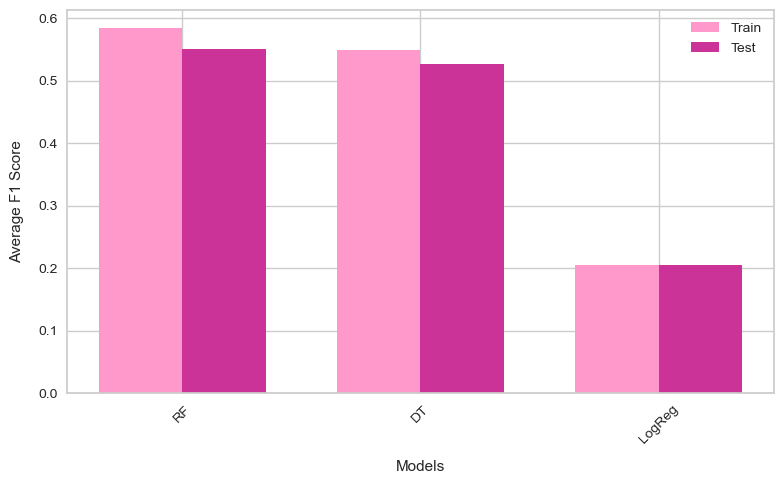

In [160]:
plot_f1_scores(results_prefix1)

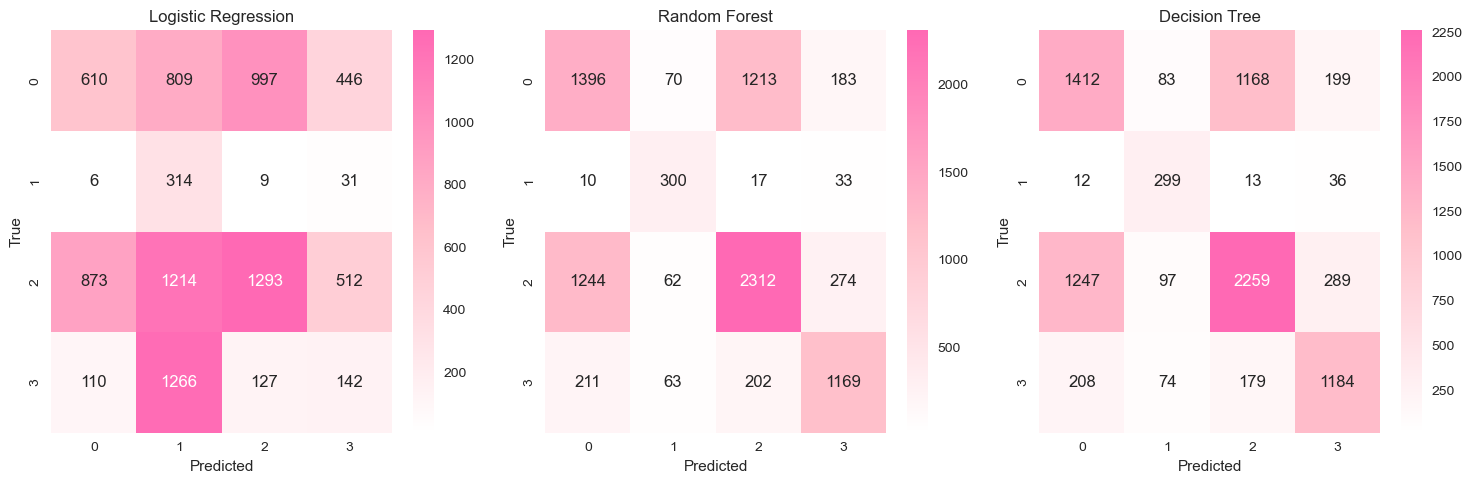

In [168]:
# Confusion matrices prefix1

# Predict on the test data using the best models
y_pred_logreg_prefix1 = best_models_prefix1['LogReg'].predict(X_test_prefix1)
y_pred_rf_prefix1 = best_models_prefix1['RF'].predict(X_test_prefix1)
y_pred_dt_prefix1 = best_models_prefix1['DT'].predict(X_test_prefix1)

# Create confusion matrices
confusion_matrix_logreg_prefix1 = confusion_matrix(y_test_prefix1, y_pred_logreg_prefix1)
confusion_matrix_rf_prefix1 = confusion_matrix(y_test_prefix1, y_pred_rf_prefix1)
confusion_matrix_dt_prefix1 = confusion_matrix(y_test_prefix1, y_pred_dt_prefix1)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix1, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix1, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix1, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [169]:
# Print classification report for the best model prefix1

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix1, y_pred_rf_prefix1))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.49      0.49      0.49      2862
           1       0.61      0.83      0.70       360
           2       0.62      0.59      0.61      3892
           3       0.70      0.71      0.71      1645

    accuracy                           0.59      8759
   macro avg       0.60      0.66      0.63      8759
weighted avg       0.59      0.59      0.59      8759



## - Prefix 2

In [139]:
# Prefix 2 predictions results
results_prefix2

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,5.007685,0.343547,0.341274,0.384034,0.384062,0.445092,0.445336
RF,49.76558,0.656594,0.564599,0.719546,0.719375,0.663634,0.662412
DT,1.731628,0.61163,0.550504,0.66563,0.66543,0.667037,0.666054


In [140]:
# Prefix 2 best models
best_models_prefix2

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', solver='saga'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=20),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

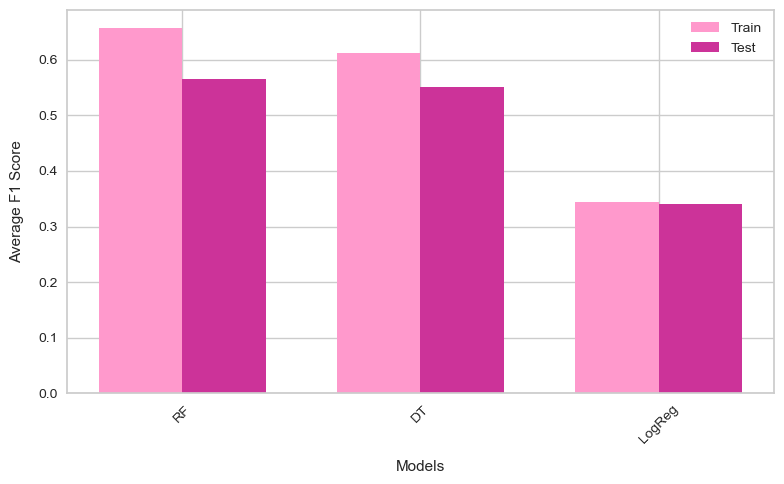

In [162]:
plot_f1_scores(results_prefix2)

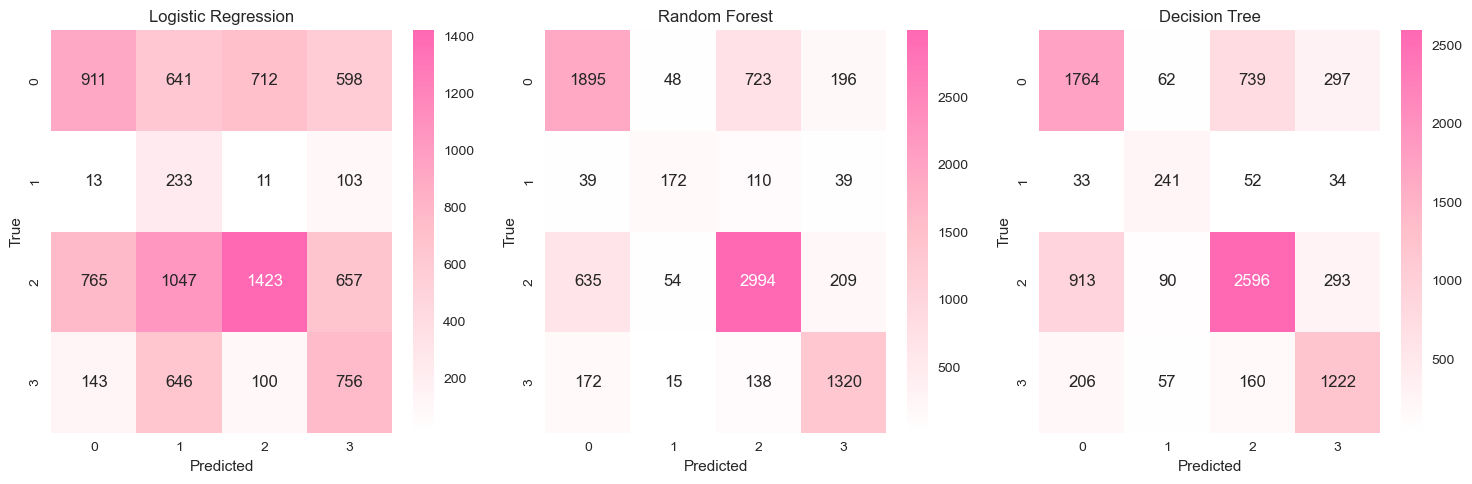

In [171]:
# Confusion matrices prefix2

# Predict on the test data using the best models
y_pred_logreg_prefix2 = best_models_prefix2['LogReg'].predict(X_test_prefix2)
y_pred_rf_prefix2 = best_models_prefix2['RF'].predict(X_test_prefix2)
y_pred_dt_prefix2 = best_models_prefix2['DT'].predict(X_test_prefix2)

# Create confusion matrices
confusion_matrix_logreg_prefix2 = confusion_matrix(y_test_prefix2, y_pred_logreg_prefix2)
confusion_matrix_rf_prefix2 = confusion_matrix(y_test_prefix2, y_pred_rf_prefix2)
confusion_matrix_dt_prefix2 = confusion_matrix(y_test_prefix2, y_pred_dt_prefix2)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix2, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix2, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix2, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [172]:
# Print classification report for the best model prefix2

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix2, y_pred_rf_prefix2))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.69      0.66      0.68      2862
           1       0.60      0.48      0.53       360
           2       0.76      0.77      0.76      3892
           3       0.75      0.80      0.77      1645

    accuracy                           0.73      8759
   macro avg       0.70      0.68      0.69      8759
weighted avg       0.73      0.73      0.73      8759



## - Prefix 3

In [141]:
# Prefix 3 predictions results
results_prefix3

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,8.714871,0.505989,0.503534,0.553345,0.553345,0.636236,0.636236
RF,49.488468,0.74988,0.681732,0.739582,0.740324,0.761298,0.760357
DT,2.886909,0.732895,0.672948,0.684039,0.684667,0.707412,0.708914


In [142]:
# Prefix 3 best models
best_models_prefix3

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=150),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

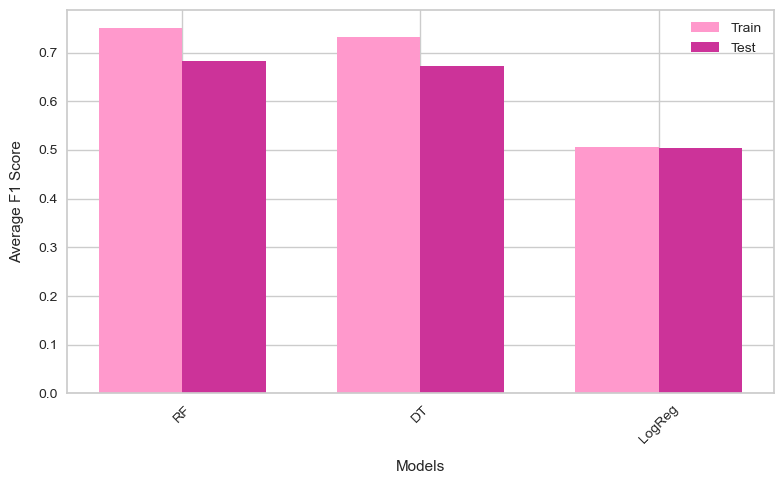

In [163]:
plot_f1_scores(results_prefix3)

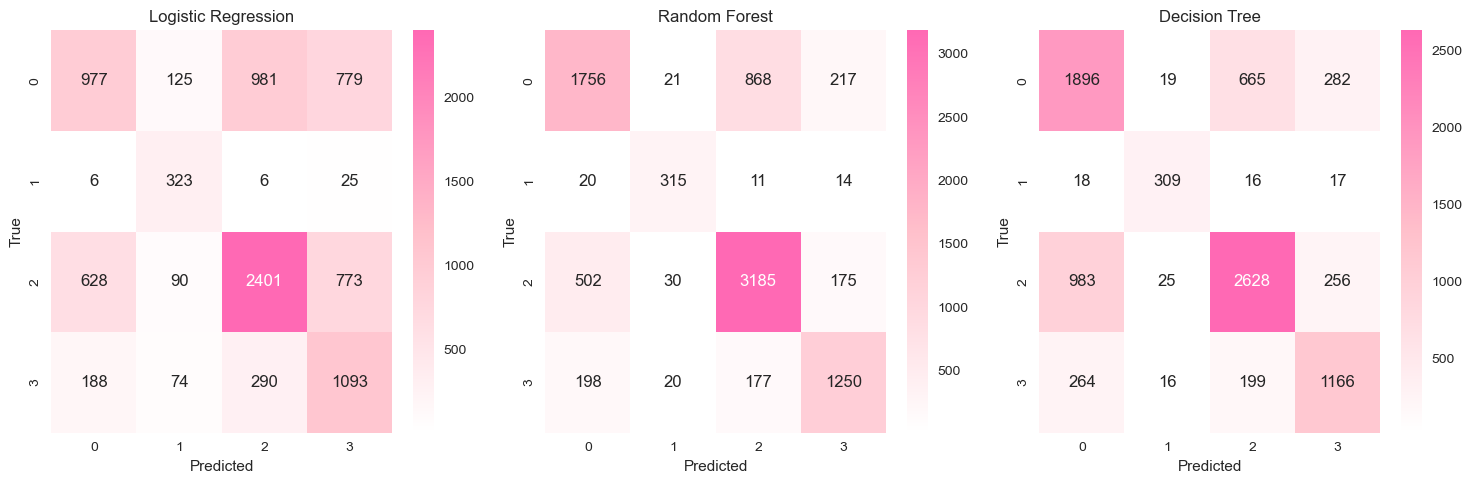

In [173]:
# Confusion matrices prefix3

# Predict on the test data using the best models
y_pred_logreg_prefix3 = best_models_prefix3['LogReg'].predict(X_test_prefix3)
y_pred_rf_prefix3 = best_models_prefix3['RF'].predict(X_test_prefix3)
y_pred_dt_prefix3 = best_models_prefix3['DT'].predict(X_test_prefix3)

# Create confusion matrices
confusion_matrix_logreg_prefix3 = confusion_matrix(y_test_prefix3, y_pred_logreg_prefix3)
confusion_matrix_rf_prefix3 = confusion_matrix(y_test_prefix3, y_pred_rf_prefix3)
confusion_matrix_dt_prefix3 = confusion_matrix(y_test_prefix3, y_pred_dt_prefix3)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix3, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix3, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix3, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [174]:
# Print classification report for the best model prefix3

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix3, y_pred_rf_prefix3))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.71      0.61      0.66      2862
           1       0.82      0.88      0.84       360
           2       0.75      0.82      0.78      3892
           3       0.75      0.76      0.76      1645

    accuracy                           0.74      8759
   macro avg       0.76      0.77      0.76      8759
weighted avg       0.74      0.74      0.74      8759



## - Prefix 4

In [143]:
# Prefix 4 predictions results
results_prefix4

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,87.195721,0.435354,0.43306,0.598633,0.598633,0.675616,0.675616
RF,51.818625,0.718115,0.641268,0.751874,0.751841,0.733461,0.738049
DT,3.72432,0.724559,0.645065,0.696935,0.695309,0.694719,0.69331


In [144]:
# Prefix 4 best models
best_models_prefix4

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=200),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

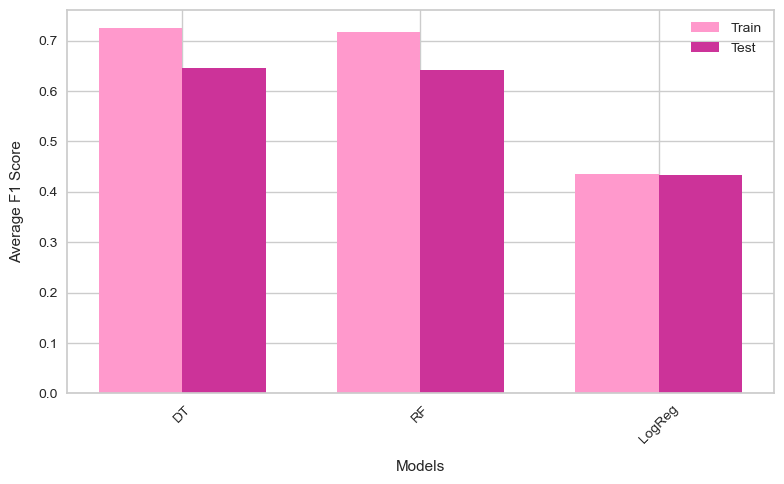

In [164]:
plot_f1_scores(results_prefix4)

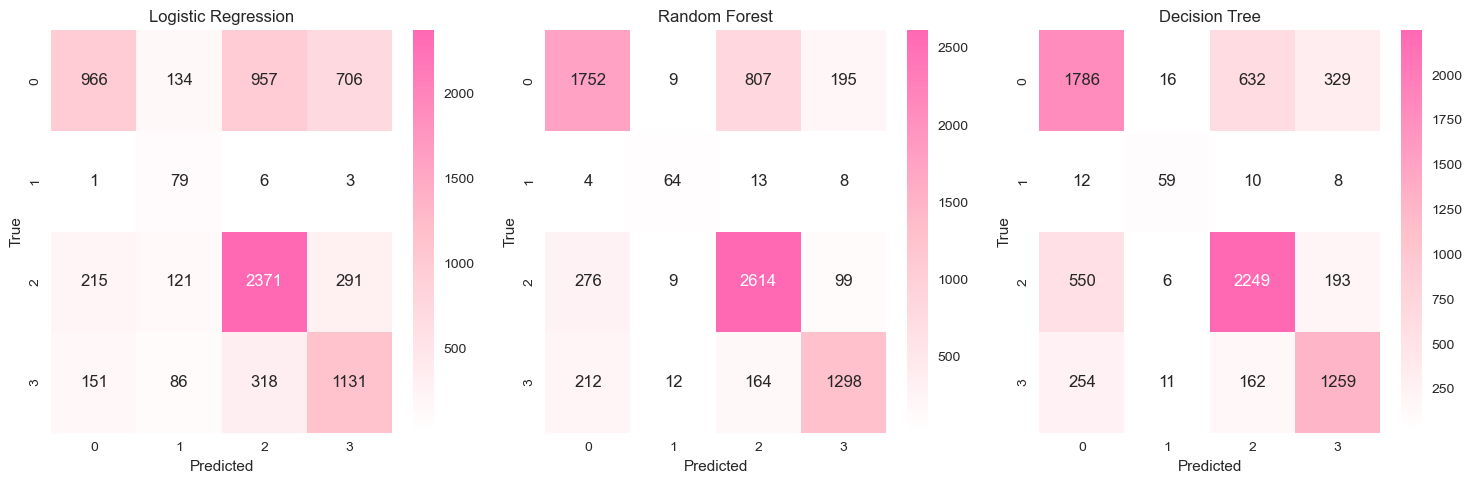

In [175]:
# Confusion matrices prefix4

# Predict on the test data using the best models
y_pred_logreg_prefix4 = best_models_prefix4['LogReg'].predict(X_test_prefix4)
y_pred_rf_prefix4 = best_models_prefix4['RF'].predict(X_test_prefix4)
y_pred_dt_prefix4 = best_models_prefix4['DT'].predict(X_test_prefix4)

# Create confusion matrices
confusion_matrix_logreg_prefix4 = confusion_matrix(y_test_prefix4, y_pred_logreg_prefix4)
confusion_matrix_rf_prefix4 = confusion_matrix(y_test_prefix4, y_pred_rf_prefix4)
confusion_matrix_dt_prefix4 = confusion_matrix(y_test_prefix4, y_pred_dt_prefix4)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix4, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix4, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix4, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [176]:
# Print classification report for the best model prefix4

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix4, y_pred_rf_prefix4))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.78      0.63      0.70      2763
           1       0.68      0.72      0.70        89
           2       0.73      0.87      0.79      2998
           3       0.81      0.77      0.79      1686

    accuracy                           0.76      7536
   macro avg       0.75      0.75      0.75      7536
weighted avg       0.76      0.76      0.76      7536



## - Prefix 5

In [145]:
# Prefix 5 predictions results
results_prefix5

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,45.623042,0.565264,0.559055,0.672958,0.672958,0.786066,0.786066
RF,26.700457,0.809399,0.733101,0.816008,0.816008,0.809441,0.81143
DT,2.30508,0.799013,0.718606,0.763074,0.762506,0.795874,0.796502


In [146]:
# Prefix 5 best models
best_models_prefix5

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', max_iter=300),
 'RF': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=200),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=13,
                        min_samples_leaf=2, min_samples_split=5)}

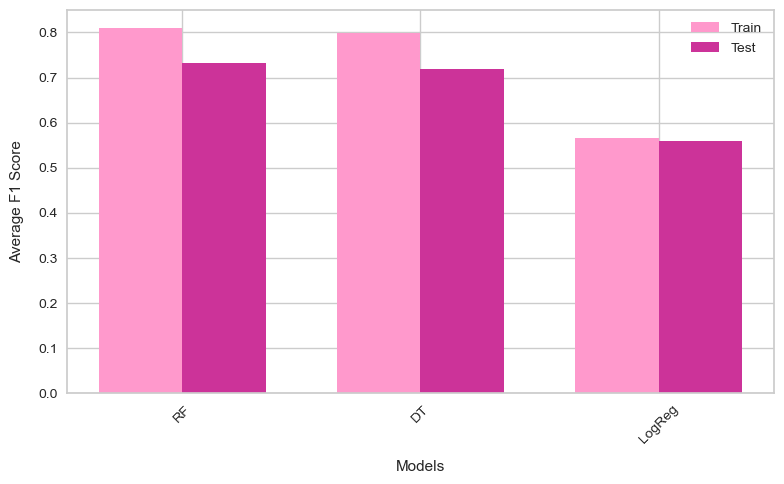

In [165]:
plot_f1_scores(results_prefix5)

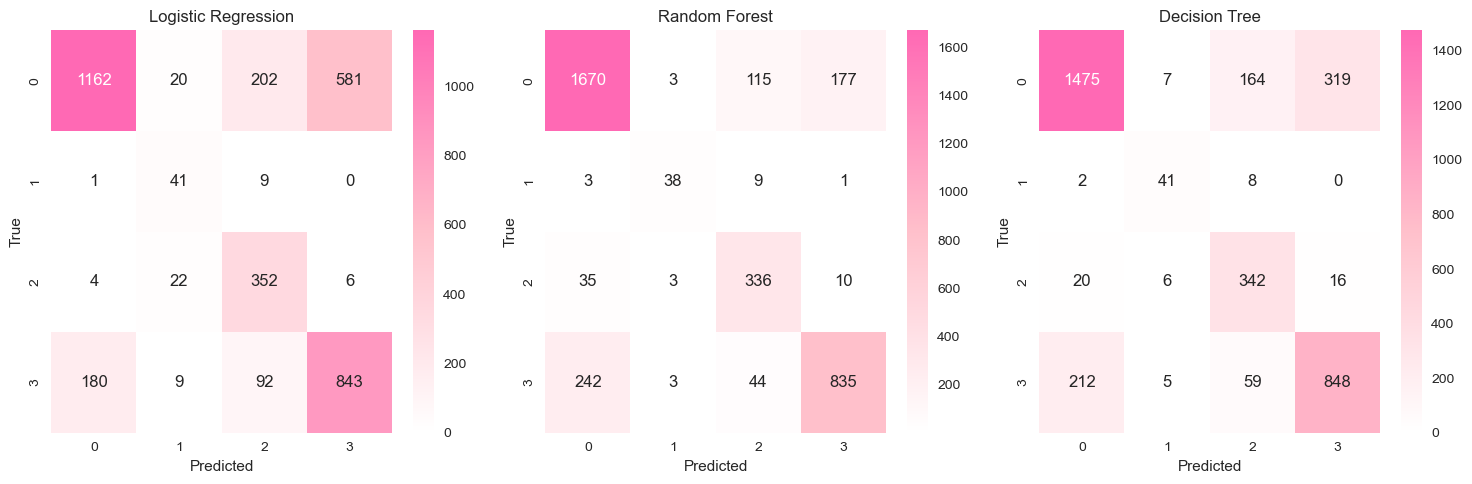

In [177]:
# Confusion matrices prefix5

# Predict on the test data using the best models
y_pred_logreg_prefix5 = best_models_prefix5['LogReg'].predict(X_test_prefix5)
y_pred_rf_prefix5 = best_models_prefix5['RF'].predict(X_test_prefix5)
y_pred_dt_prefix5 = best_models_prefix5['DT'].predict(X_test_prefix5)

# Create confusion matrices
confusion_matrix_logreg_prefix5 = confusion_matrix(y_test_prefix5, y_pred_logreg_prefix5)
confusion_matrix_rf_prefix5 = confusion_matrix(y_test_prefix5, y_pred_rf_prefix5)
confusion_matrix_dt_prefix5 = confusion_matrix(y_test_prefix5, y_pred_dt_prefix5)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix5, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix5, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix5, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [178]:
# Print classification report for the best model prefix5

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix5, y_pred_rf_prefix5))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1965
           1       0.81      0.75      0.78        51
           2       0.67      0.88      0.76       384
           3       0.82      0.74      0.78      1124

    accuracy                           0.82      3524
   macro avg       0.79      0.80      0.79      3524
weighted avg       0.82      0.82      0.82      3524



## - Prefix 6

In [147]:
# Prefix 6 predictions results
results_prefix6

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,8.158604,0.600461,0.57943,0.688699,0.688699,0.77866,0.77866
RF,8.63863,0.877535,0.750415,0.750685,0.746918,0.799544,0.794263
DT,0.771366,0.854017,0.732924,0.712329,0.712671,0.779706,0.779706


In [148]:
# Prefix 6 best models
best_models_prefix6

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=200),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                        min_samples_split=5)}

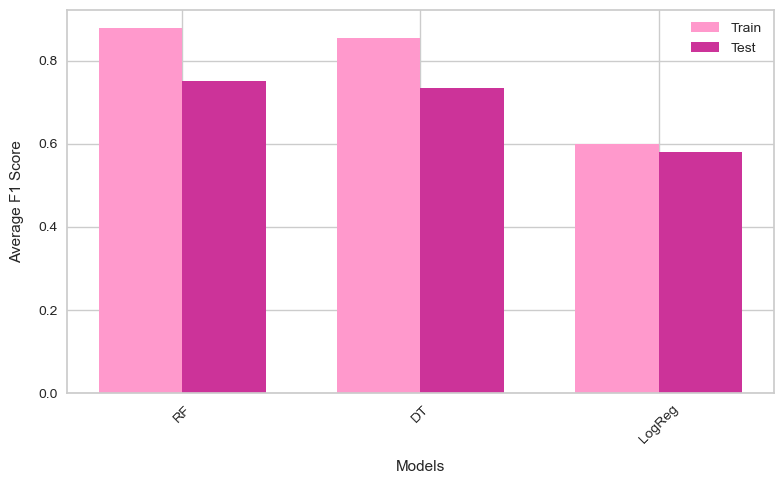

In [166]:
plot_f1_scores(results_prefix6)

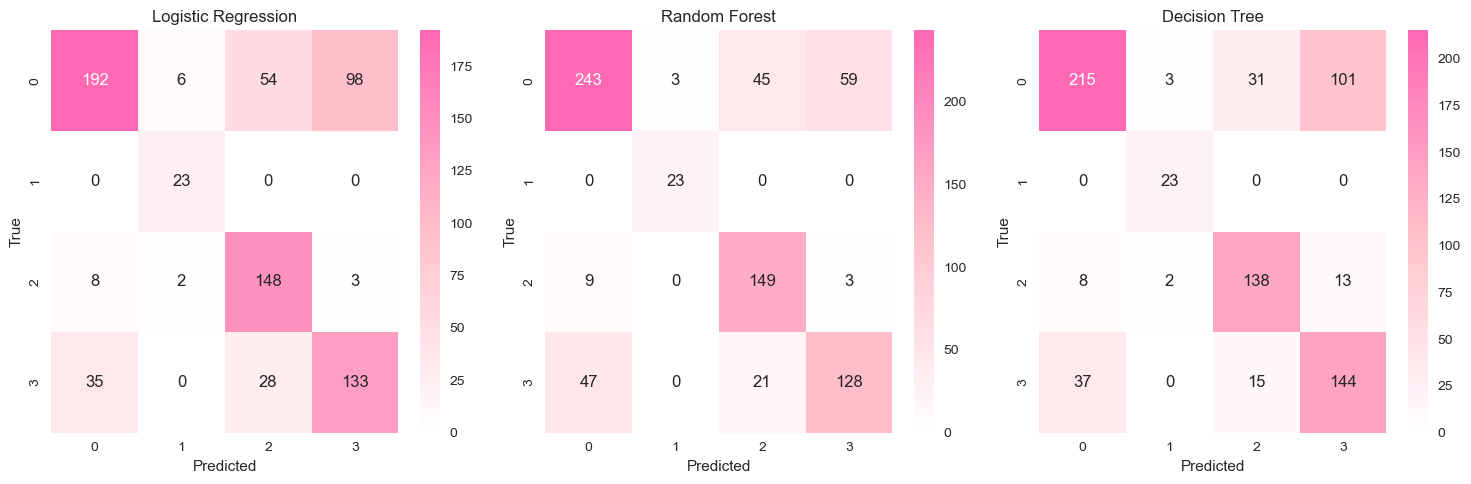

In [179]:
# Confusion matrices prefix6

# Predict on the test data using the best models
y_pred_logreg_prefix6 = best_models_prefix6['LogReg'].predict(X_test_prefix6)
y_pred_rf_prefix6 = best_models_prefix6['RF'].predict(X_test_prefix6)
y_pred_dt_prefix6 = best_models_prefix6['DT'].predict(X_test_prefix6)

# Create confusion matrices
confusion_matrix_logreg_prefix6 = confusion_matrix(y_test_prefix6, y_pred_logreg_prefix6)
confusion_matrix_rf_prefix6 = confusion_matrix(y_test_prefix6, y_pred_rf_prefix6)
confusion_matrix_dt_prefix6 = confusion_matrix(y_test_prefix6, y_pred_dt_prefix6)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix6, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix6, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix6, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [180]:
# Print classification report for the best model prefix6

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix6, y_pred_rf_prefix6))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.81      0.69      0.75       350
           1       0.88      1.00      0.94        23
           2       0.69      0.93      0.79       161
           3       0.67      0.65      0.66       196

    accuracy                           0.74       730
   macro avg       0.77      0.82      0.79       730
weighted avg       0.75      0.74      0.74       730



## - Prefix 7

In [149]:
# Prefix 7 predictions results
results_prefix7

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,3.483764,0.742163,0.696457,0.70754,0.708449,0.80766,0.80766
RF,4.283767,0.954313,0.869934,0.82564,0.833805,0.875239,0.869412
DT,0.282518,0.928591,0.850201,0.812012,0.812012,0.877394,0.876613


In [150]:
# Prefix 7 best models
best_models_prefix7

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, solver='saga'),
 'RF': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2)}

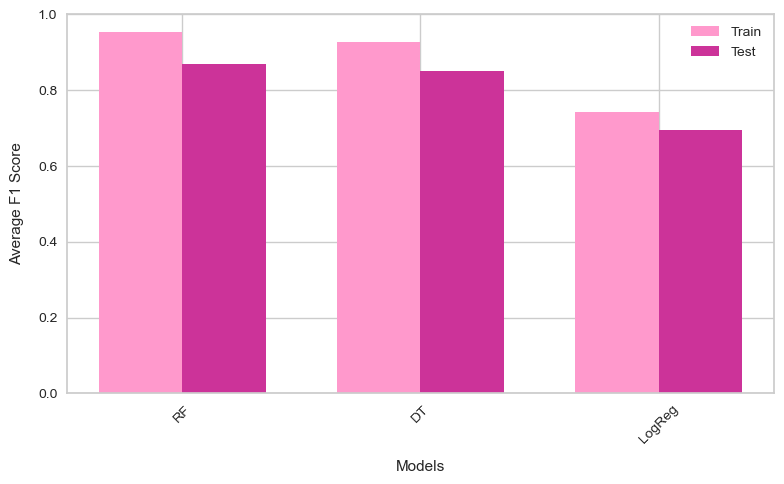

In [167]:
plot_f1_scores(results_prefix7)

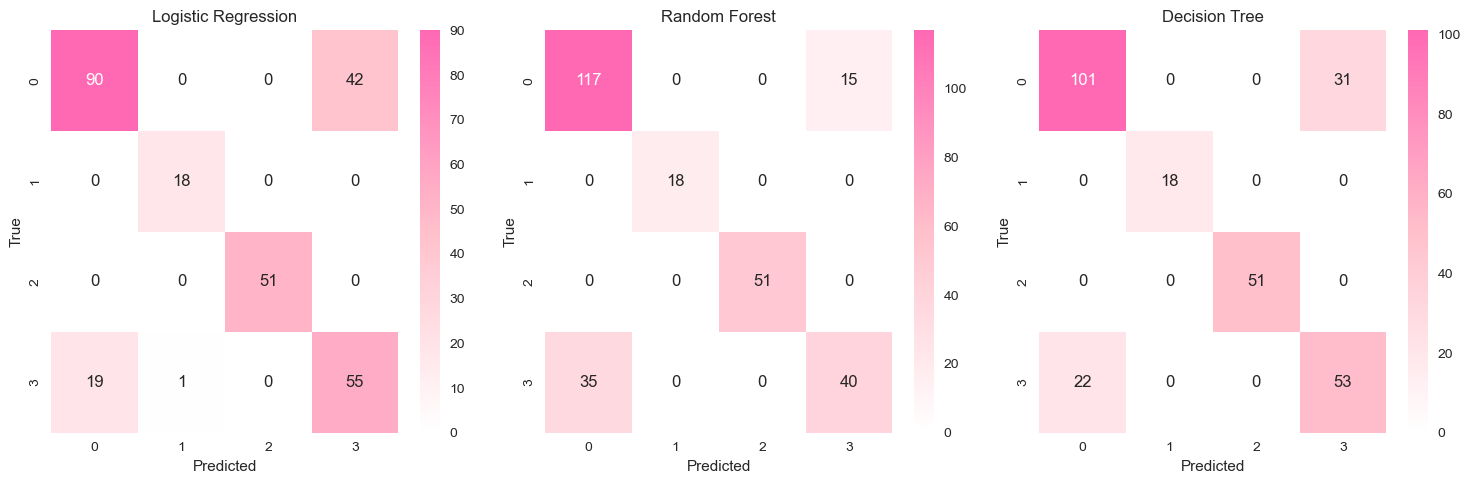

In [181]:
# Confusion matrices prefix7

# Predict on the test data using the best models
y_pred_logreg_prefix7 = best_models_prefix7['LogReg'].predict(X_test_prefix7)
y_pred_rf_prefix7 = best_models_prefix7['RF'].predict(X_test_prefix7)
y_pred_dt_prefix7 = best_models_prefix7['DT'].predict(X_test_prefix7)

# Create confusion matrices
confusion_matrix_logreg_prefix7 = confusion_matrix(y_test_prefix7, y_pred_logreg_prefix7)
confusion_matrix_rf_prefix7 = confusion_matrix(y_test_prefix7, y_pred_rf_prefix7)
confusion_matrix_dt_prefix7 = confusion_matrix(y_test_prefix7, y_pred_dt_prefix7)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Custom colormap
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["white", "pink", "hotpink"])

# Logistic Regression
sns.heatmap(confusion_matrix_logreg_prefix7, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Random Forest
sns.heatmap(confusion_matrix_rf_prefix7, annot=True, fmt='d', cmap=pink_cmap, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Decision Tree
sns.heatmap(confusion_matrix_dt_prefix7, annot=True, fmt='d', cmap=pink_cmap, ax=axes[2])
axes[2].set_title('Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [182]:
# Print classification report for the best model prefix7

print("Classification Report for Random Forest:\n", classification_report(y_test_prefix7, y_pred_rf_prefix7))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82       132
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        51
           3       0.73      0.53      0.62        75

    accuracy                           0.82       276
   macro avg       0.87      0.85      0.86       276
weighted avg       0.82      0.82      0.81       276

